# Statistical models

## Importing libraries

In [1]:
# Data opening libraries
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import json
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

# Plotting libraries
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch

# Statistical model fitting libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Linear and quadratic regressions

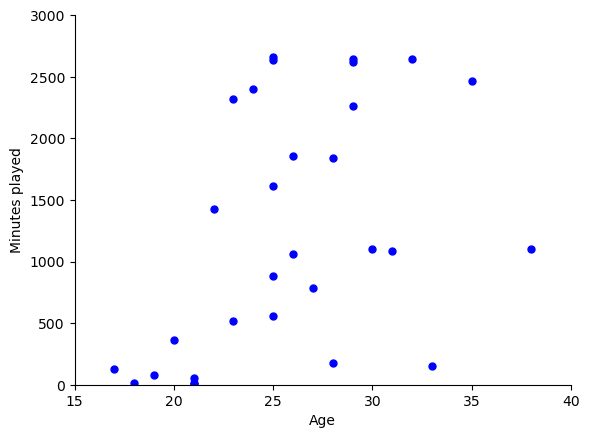

In [2]:
# Defining the number of observations we want
num_obs = 30

# Opening data and producing data frame
laliga_df=pd.read_csv("playerstats.csv",delimiter=',')
minutes_model = pd.DataFrame()
minutes_model = minutes_model.assign(minutes=laliga_df['Min'][0:num_obs])
minutes_model = minutes_model.assign(age=laliga_df['Age'][0:num_obs])

# Making an age squared column so we can use polynomial model.
minutes_model = minutes_model.assign(age_squared=np.power(laliga_df['Age'][0:num_obs],2))

# Plotting the data
fig, ax = plt.subplots(num=1)
ax.plot(minutes_model['age'], minutes_model['minutes'], linestyle='none', marker= '.', markersize= 10, color='blue')
ax.set_ylabel('Minutes played')
ax.set_xlabel('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((15,40))
plt.ylim((0,3000))
plt.show()

In [3]:
# Fitting the model nd printing its parameters
model_fit = smf.ols(formula='minutes ~ age', data=minutes_model).fit()
print(model_fit.summary())
b = model_fit.params

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     6.736
Date:                Wed, 30 Aug 2023   Prob (F-statistic):             0.0149
Time:                        14:45:52   Log-Likelihood:                -245.96
No. Observations:                  30   AIC:                             495.9
Df Residuals:                      28   BIC:                             498.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1004.3775    884.123     -1.136      0.2

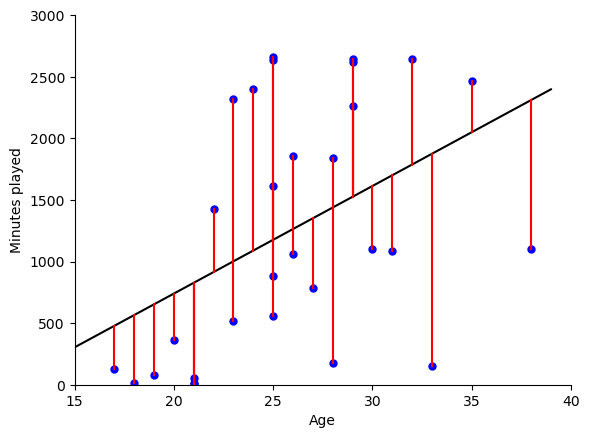

In [4]:
# Plotting the data
fig, ax = plt.subplots(num=1)
ax.plot(minutes_model['age'], minutes_model['minutes'], linestyle='none', marker= '.', markersize= 10, color='blue')
ax.set_ylabel('Minutes played')
ax.set_xlabel('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((15,40))
plt.ylim((0,3000))

# Creating the lines through the data
x = np.arange(40,step=1)
y = b[0] + b[1] * x # np.mean(minutes_model['minutes']) * np.ones(40)
ax.plot(x, y, color='black')

# Showing distances to line for each point
for i, a in enumerate(minutes_model['age']):
    ax.plot([a,a],[minutes_model['minutes'][i], b[0] + b[1] * a ], color='red') # np.mean(minutes_model['minutes']
plt.show()

                            OLS Regression Results                            
Dep. Variable:                minutes   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     6.660
Date:                Wed, 30 Aug 2023   Prob (F-statistic):            0.00446
Time:                        14:45:53   Log-Likelihood:                -243.18
No. Observations:                  30   AIC:                             492.4
Df Residuals:                      27   BIC:                             496.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9034.3591   3520.443     -2.566      

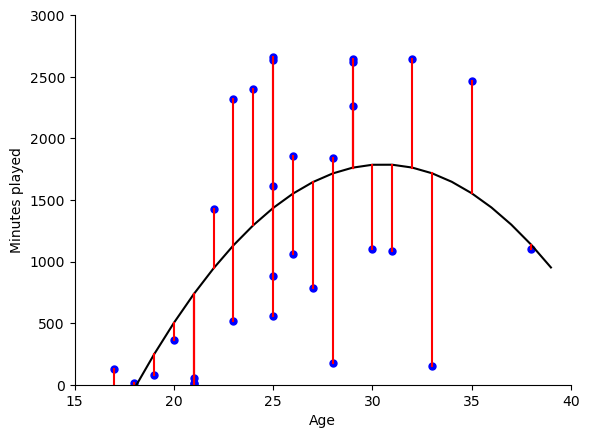

In [5]:
# Fitting the model
model_fit=smf.ols(formula='minutes  ~ age + age_squared  ', data=minutes_model).fit()
print(model_fit.summary())
b=model_fit.params

# Comparing the fit
fig, ax = plt.subplots(num=1)
ax.plot(minutes_model['age'], minutes_model['minutes'], linestyle='none', marker= '.', markersize= 10, color='blue')
ax.set_ylabel('Minutes played')
ax.set_xlabel('Age')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim((15,40))
plt.ylim((0,3000))
x = np.arange(40,step=1)
y = b[0] + b[1]*x + b[2]*x*x
ax.plot(x, y, color='black')

# Showing distances to line for each point
for i,a in enumerate(minutes_model['age']):
    ax.plot([a,a],[minutes_model['minutes'][i], b[0] + b[1]*a + b[2]*a*a], color='red')
plt.show()

## Fitting an xG model

### Data preprocessing

In [6]:
# Loading and storing data into train data frame
path = r"D:\WyScoutOpenData\events\events_France.json"
with open(path) as f:
    data = json.load(f)
train = pd.DataFrame(data)

# Getting shots
shots = train.loc[train['subEventName'] == 'Shot']

# Getting shot coordinates as separate columns
shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)

# Calculating distance and angle
shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
shots["Goal"] = shots.tags.apply(lambda x: 1 if {'id':101} in x else 0).astype(object)

### Plotting shot location

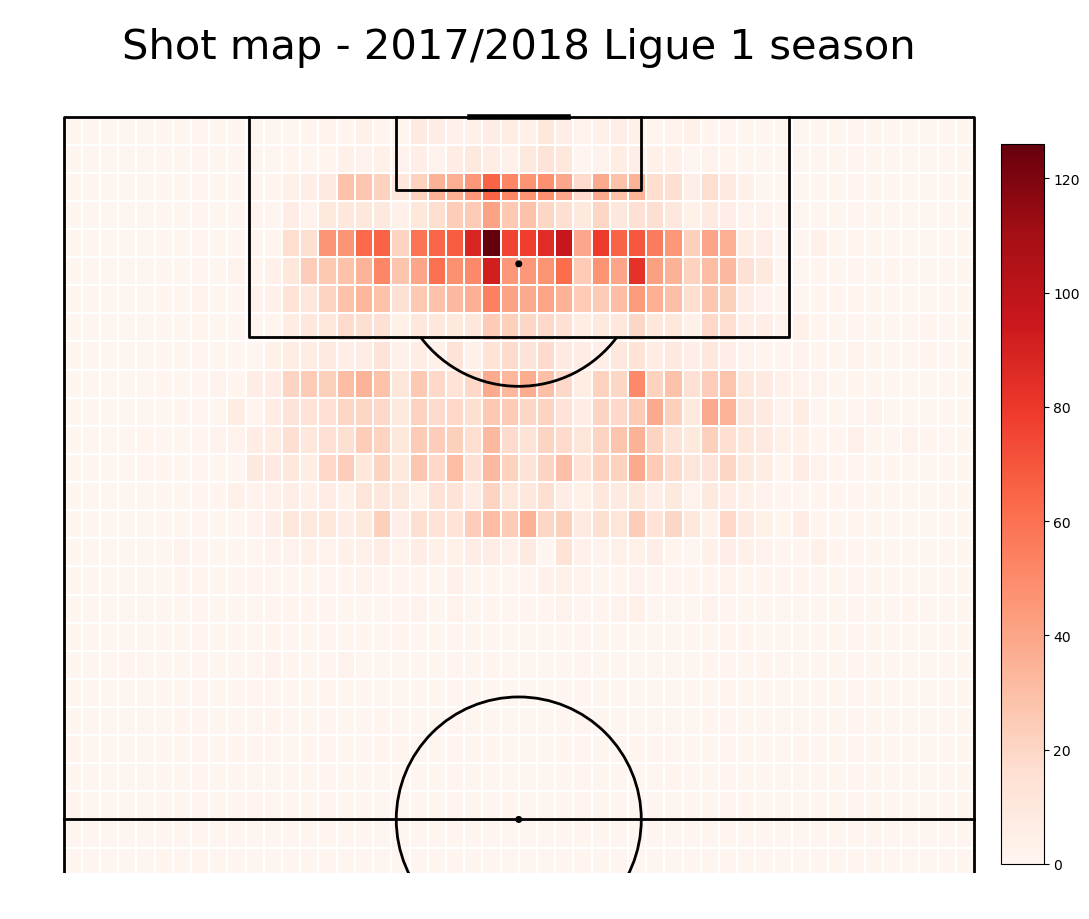

In [7]:
# Ploting pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#subtracting x from 105 but not y from 68 because of inverted Wyscout axis

# Calculating number of shots in each bin
bin_statistic_shots = pitch.bin_statistic(105 - shots.X, shots.Y, bins=50)

# Making heatmap
pcm = pitch.heatmap(bin_statistic_shots, ax=ax["pitch"], cmap='Reds', edgecolor='white', linewidth = 0.01)

# Making legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot map - 2017/2018 Ligue 1 season' , fontsize = 30)
plt.show()

### Plotting goal location

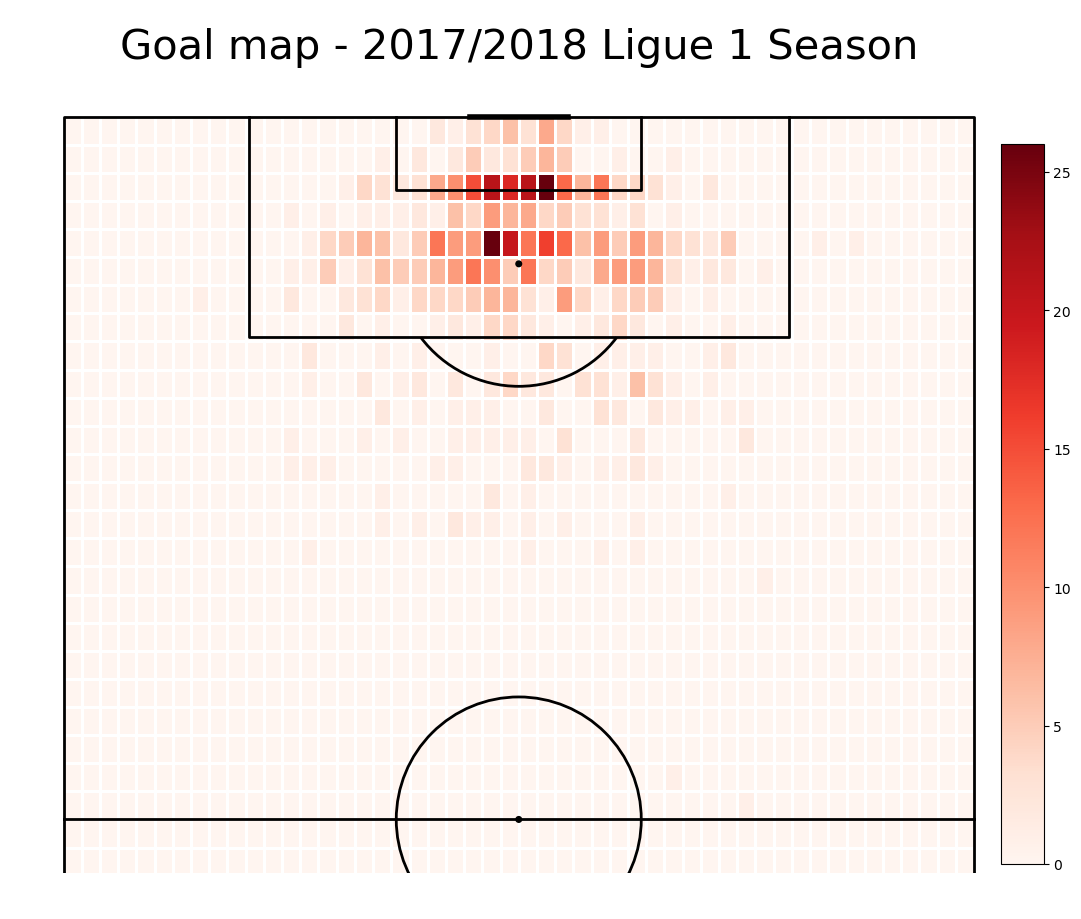

In [8]:
# Keeping goals
goals = shots.loc[shots["Goal"] == 1]

# Plotting pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Calculating number of goals in each bin
bin_statistic_goals = pitch.bin_statistic(105 - goals.X, goals.Y, bins=50)

# Plotting heatmap
pcm = pitch.heatmap(bin_statistic_goals, ax=ax["pitch"], cmap='Reds', edgecolor='white')

# Making legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal map - 2017/2018 Ligue 1 Season' , fontsize = 30)
plt.show()

### Plotting the probability of scoring

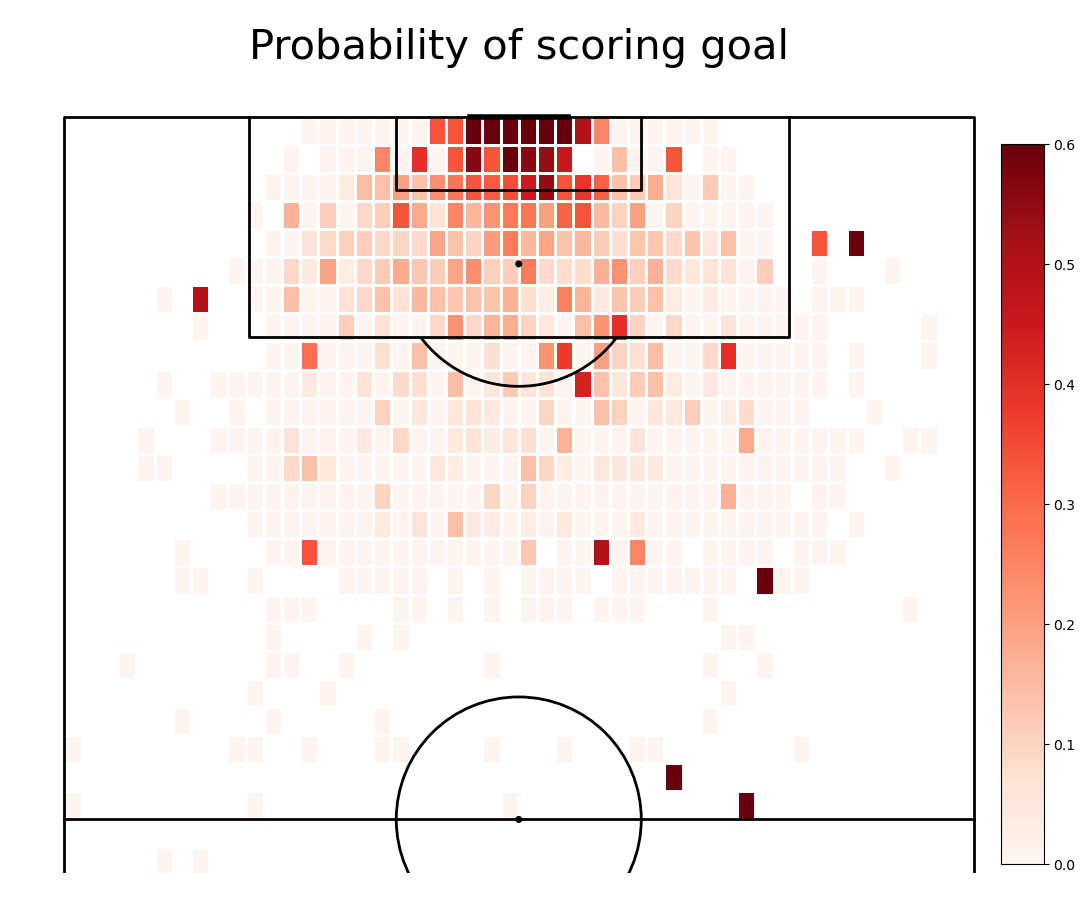

In [9]:
# Plotting pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)


# Normalizing number of goals by number of shots
bin_statistic = pitch.bin_statistic(105 - shots.X, shots.Y, bins = 50)
bin_statistic["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]

# Plotting heatmap
pcm = pitch.heatmap(bin_statistic, ax=ax["pitch"], cmap='Reds', edgecolor='white', vmin = 0, vmax = 0.6)

# Making legend
ax_cbar = fig.add_axes((0.95, 0.05, 0.04, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Probability of scoring goal' , fontsize = 30)
plt.show()

### Investigating the relation between goals and angle

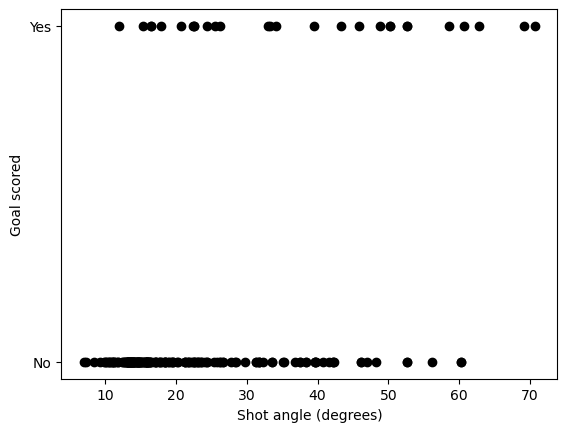

In [10]:
# Keeping the first 200 shots
shots_200=shots.iloc[:200]

# Plotting the first 200 shots goal angle
fig, ax = plt.subplots()
ax.plot(shots_200['Angle']*180/np.pi, shots_200['Goal'], linestyle='none', marker= '.', markersize= 12, color='black')

# Making legend
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

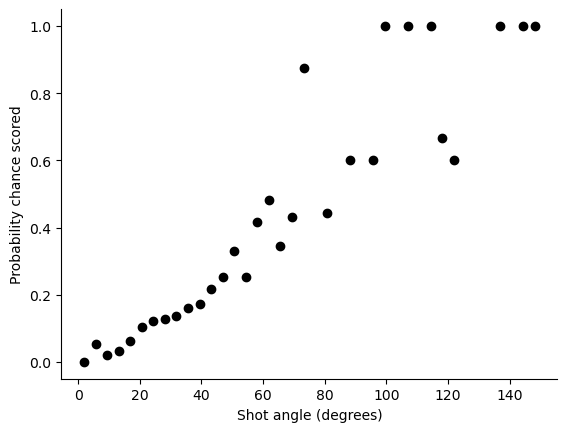

In [11]:
# Counting the number of shots from angle
shotcount_dist = np.histogram(shots['Angle']*180/np.pi, bins=40, range=[0, 150])

# Counting the number of goals from angle
goalcount_dist = np.histogram(goals['Angle']*180/np.pi, bins=40, range=[0, 150])
np.seterr(divide='ignore', invalid='ignore')

# Calculating the probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
angle = shotcount_dist[1]
midangle = (angle[:-1] + angle[1:])/2

# Making plot
fig,ax = plt.subplots()
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8327
Model:                                GLM   Df Residuals:                     8325
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2499.3
Date:                    Wed, 30 Aug 2023   Deviance:                       4998.5
Time:                            14:46:09   Pearson chi2:                 8.14e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.06844
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

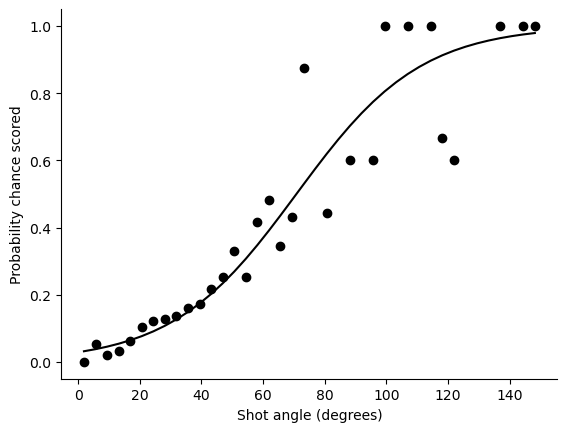

In [12]:
# Creating model
test_model = smf.glm(formula="Goal ~ Angle" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Getting parameters
b = test_model.params

# Calculating xG
xGprob = 1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180))
fig, ax = plt.subplots()

# Plotting data
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markersize= 12, color='black')

# Plotting line
ax.plot(midangle, xGprob, linestyle='solid', color='black')

# Making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Investigating the relationship between probability of scoring goals and distance to goal

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8327
Model:                                GLM   Df Residuals:                     8325
Model Family:                    Binomial   Df Model:                            1
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2488.6
Date:                    Wed, 30 Aug 2023   Deviance:                       4977.2
Time:                            14:46:09   Pearson chi2:                 1.09e+04
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07083
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

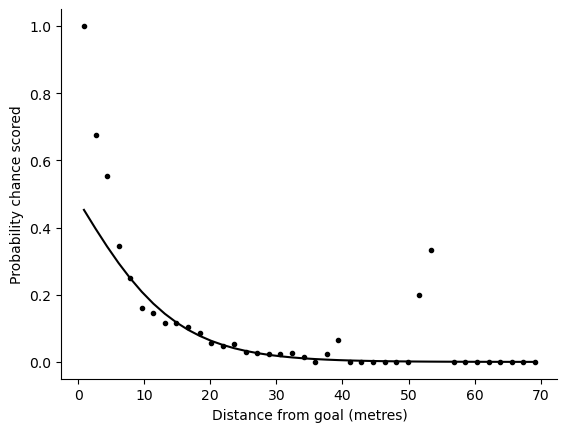

In [13]:
# Counting the number of shots
shotcount_dist = np.histogram(shots['Distance'], bins=40, range=[0, 70])

# Counting the number of goals
goalcount_dist = np.histogram(goals['Distance'], bins=40, range=[0, 70])

# Calculating the empirical probability of scoring
prob_goal = np.divide(goalcount_dist[0],shotcount_dist[0])
distance = shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2

# Plotting data
fig, ax = plt.subplots()
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')

# Making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Making single variable model of distance
test_model = smf.glm(formula="Goal ~ Distance" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Getting parameters
b = test_model.params

# Calculating xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance))

# Plotting line
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8327
Model:                                GLM   Df Residuals:                     8324
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2475.7
Date:                    Wed, 30 Aug 2023   Deviance:                       4951.3
Time:                            14:46:09   Pearson chi2:                 8.69e+03
No. Iterations:                         6   Pseudo R-squ. (CS):            0.07371
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

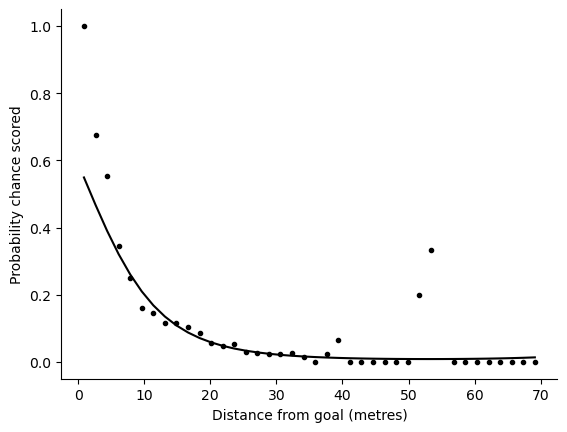

In [14]:
# Calculating distance squared
shots["D2"] = shots['Distance']**2

# Adding it to the model
test_model = smf.glm(formula="Goal ~ Distance + D2" , data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Getting parameters
b = test_model.params

# Calculating xG
xGprob=1/(1+np.exp(b[0]+b[1]*middistance+b[2]*pow(middistance,2)))

# Plotting data
fig, ax = plt.subplots()
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')

# Making legend
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()

### Investigating the relationship between probability of scoring goals, distance to goal AND angle

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 8327
Model:                                GLM   Df Residuals:                     8319
Model Family:                    Binomial   Df Model:                            7
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -2456.3
Date:                    Wed, 30 Aug 2023   Deviance:                       4912.7
Time:                            14:46:10   Pearson chi2:                 8.40e+03
No. Iterations:                         8   Pseudo R-squ. (CS):            0.07800
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

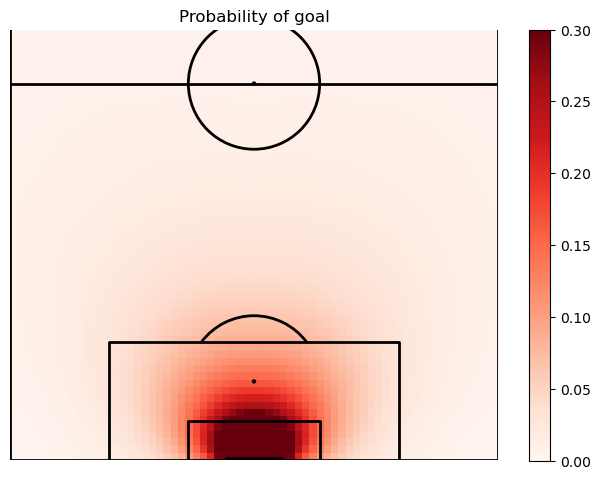

In [15]:
# Creating extra variables
shots["X2"] = shots['X']**2
shots["C2"] = shots['C']**2
shots["AX"]  = shots['Angle']*shots['X']

# list the model variables you want here
model_variables = ['Angle','Distance','X','C', "X2", "C2", "AX"]
model=''
for v in model_variables[:-1]:
    model = model + v + ' + '
model = model + model_variables[-1]

# Fitting the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots, family=sm.families.Binomial()).fit()
print(test_model.summary())

# Getting parameters
b = test_model.params

# Defining funcion to calcualte xG value for more general model
def calculate_xG(sh):
   bsum = b[0]
   for i,v in enumerate(model_variables):
       bsum = bsum + b[i+1] * sh[v]
   xG = 1/(1 + np.exp(bsum))
   return xG

# Adding an xG to my dataframe
xG=shots.apply(calculate_xG, axis=1)
shots = shots.assign(xG=xG)

# Creating a 2D map of xG
pgoal_2d=np.zeros((68,68))
for x in range(68):
    for y in range(68):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-68/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-68/2)**2)
        sh['D2'] = x**2 + abs(y-68/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-68/2)
        sh['C2'] = (y-68/2)**2

        pgoal_2d[x,y] =  calculate_xG(sh)

# Plotting pitch
pitch = VerticalPitch(line_color='black', half = True, pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.draw()

# Plotting probability
pos = ax.imshow(pgoal_2d, extent=[-1,68,68,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3, zorder = 1)
fig.colorbar(pos, ax=ax)

# Making legend
ax.set_title('Probability of goal')
plt.xlim((0,68))
plt.ylim((0,60))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Testing the model fit

Mcfaddens Rsquared 0.12099474371716012


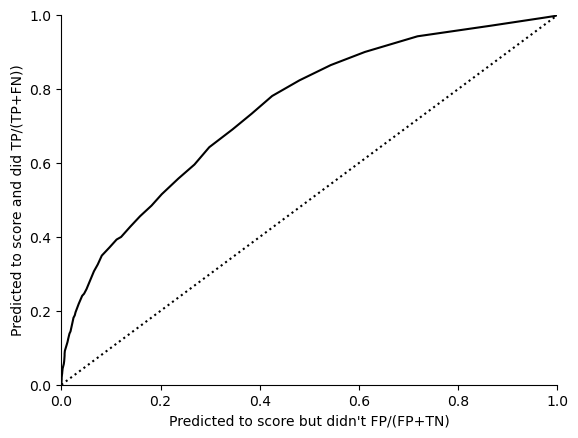

In [16]:
# Calculating Mcfaddens Rsquared for logistic regression
null_model = smf.glm(formula="Goal ~ 1 ", data=shots, family=sm.families.Binomial()).fit()
print("Mcfaddens Rsquared", 1 - test_model.llf / null_model.llf)

# Making ROC curve
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for j, shot in shots.iterrows():
        if (shot['Goal'] == 1):
            if (shot['xG'] > threshold):
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if (shot['Goal'] == 0):
            if (shot['xG'] > threshold):
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

# Plotting data
fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel("Predicted to score and did TP/(TP+FN))")
ax.set_xlabel("Predicted to score but didn't FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()